In [1]:
#from sam2.sam2_image_predictor import SAM2ImagePredictor
#print(dir(sam2))
import torch
from sam2.sam2_image_predictor import SAM2ImagePredictor
#from sam2.build_sam import build_sam2
#from sam2.sam2_image_predictor import SAM2ImagePredictor

#from transformers import Owlv2Processor, Owlv2ForObjectDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
from config import topview_vec, sideview_vec, tcp_X_offset, tcp_Y_offset, tcp_Z_offset, n_depth_samples, vit_thresh, tower
# sys.path.append("../")
import numpy as np
from magpie_control import realsense_wrapper as real
from magpie_control.ur5 import UR5_Interface as robot
from magpie_perception.label_owlv2 import LabelOWLv2

import pyrealsense2 as rs
import time
import os

import random
from openai import OpenAI

from control_scripts import goto_vec, get_pictures, get_frames
from gpt_planning import get_gpt_next_instruction, print_json
from APIKeys import API_KEY


/home/user/sam2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2024-11-13 17:56:15.350445: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 17:56:15.350474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 17:56:15.351460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 17:56:15.357165: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-13 17:56:16.020011: W tensorflow/compiler/tf2

In [2]:
myrs = real.RealSense()
myrs.initConnection()
myrobot = robot()
print(f"starting robot from nb")
myrobot.start()
label_vit = LabelOWLv2(topk=1, score_threshold=vit_thresh, cpu_override=False)
label_vit.model.eval()
#print(dir(label_vit.model))
print(f"{label_vit.model.device=}")

sam_predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")
print(f"{sam_predictor.model.device=}")

client = OpenAI(
        api_key= API_KEY,
    )


starting robot from nb
Found Dynamixel Port:
/dev/ttyACM0

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
label_vit.model.device=device(type='cuda', index=0)
sam_predictor.model.device=device(type='cuda', index=0)


In [3]:
myrobot.open_gripper()


Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [4]:
def get_depth_frame_intrinsics(rs_wrapper):
    rgb_frame, depth_frame = get_frames(rs_wrapper)
    intrinsics = depth_frame.profile.as_video_stream_profile().intrinsics
    return depth_frame, intrinsics

def get_topview_depth(point_list, UR_interface, rs_wrapper):
    goto_vec(UR_interface, topview_vec)
    depth_measurements = [[] for p in point_list]
    intrinsics = None
    for i in range(n_depth_samples):
        depth_frame, intrinsics = get_depth_frame_intrinsics(rs_wrapper)
        for i, (x, y) in enumerate(point_list):
            depth_val = depth_frame.get_distance(x, y)  # in meters
            if depth_val > 0:
                depth_measurements[i].append(depth_val)
    
    depth_measurements = [np.array(point_measurements) for point_measurements in depth_measurements]
    final_depth_measurements = [0 for point in point_list]
    for i, measurements in enumerate(depth_measurements):
        std = np.std(measurements)
        mean = np.mean(measurements)
        in_std_mask = np.abs(measurements-mean) <= std
        depth_measurements = measurements[in_std_mask]
        #print(f"{depth_measurements=}")
        depth_val = sum(measurements)/len(measurements)
        #print(f"{depth_val=}")
        assert depth_val > 0, f"not able to get depth val after {n_depth_samples} samples {depth_val=}"
        final_depth_measurements[i] = depth_val
    return final_depth_measurements

def deproject_top_view_point(K, pixel_x, pixel_y, depth):
    return rs.rs2_deproject_pixel_to_point(K, [pixel_x, pixel_y], depth)

In [5]:
"""

pick_place_BB takes the color of the block that needs to be picked up and the color of the block 
to be placed on and gives the cords of where each are located as {xmin, ymin, xmax, ymax, strlabel}

"""
def get_bb_patch(bb, edge_color = "r"):
    rect = patches.Rectangle(
                            (bb["xmin"], bb["ymin"]),
                                bb["xmax"] - bb["xmin"],
                                bb["ymax"] - bb["ymin"],
                                linewidth=2, edgecolor=edge_color, facecolor='none'
                            )
    return rect

def topview_pick_place_BB(UR_Interface, rs_wrapper, pick_str, place_str, display= False):
    #print(place_str)
    #initlize local variables
    goto_vec(UR_Interface, topview_vec)
    rgb_img, depth_img = get_pictures(rs_wrapper)
    pick_cord_dict, place_cord_dict = {} , {}
    str_cords = ["xmin", "ymin", "xmax", "ymax"]
    queries = [pick_str, place_str]
    abbrevq = [pick_str, place_str]
    
    #pick bboxes and cords
    with torch.no_grad():
        pick_bbox = label_vit.label(rgb_img, queries[0], abbrevq[0], plot=False, topk=True)
        place_bbox = label_vit.label(rgb_img, queries[1], abbrevq[1], plot=False, topk=True)

    pick_bbox_cords = pick_bbox[1][0].tolist()
    for pick, cord in zip(pick_bbox_cords, str_cords):
        #print(f"{pick=}")
        pick_cord_dict[cord] = int(pick)
    
    #place bboxes and cords
    place_bbox_cords = place_bbox[1][0].tolist()
    for place , cord in zip(place_bbox_cords, str_cords):
        place_cord_dict[cord] = int(place)
    
    invalid_border_px_x = 200
    invalid_border_px_y = 20
    print(f"{rgb_img.shape=}")
    print(f"{place_cord_dict=}")

    for k in ["xmin", "xmax"]:
        pick_cord_dict[k] = np.clip(pick_cord_dict[k], 0+invalid_border_px_x, rgb_img.shape[1]-invalid_border_px_x)
        place_cord_dict[k] = np.clip(place_cord_dict[k], 0+invalid_border_px_x, rgb_img.shape[1]-invalid_border_px_x)
    for k in ["ymin", "ymax"]:
        pick_cord_dict[k] = np.clip(pick_cord_dict[k], 0+invalid_border_px_y, rgb_img.shape[0]-invalid_border_px_y)
        place_cord_dict[k] = np.clip(place_cord_dict[k], 0+invalid_border_px_y, rgb_img.shape[0]-invalid_border_px_y)
    print(f"{place_cord_dict=}")
    

    pick_cord_dict["strlabel"] = pick_str
    place_cord_dict["strlabel"] = place_str

    pick_cord_dict["xCenter"] = int((pick_cord_dict['xmin'] + pick_cord_dict["xmax"])/2)
    pick_cord_dict["yCenter"] = int((pick_cord_dict['ymin'] + pick_cord_dict["ymax"])/2)

    place_cord_dict["xCenter"] = int((place_cord_dict['xmin'] + place_cord_dict["xmax"])/2)
    place_cord_dict["yCenter"] = int((place_cord_dict['ymin'] + place_cord_dict["ymax"])/2)
    
    #print(f"{pick_cord_dict=}")
    #print(f"{place_cord_dict=}")

    if display:
        fig, axes = plt.subplots(nrows=2, ncols=2)
        axes[0, 0].imshow(rgb_img)
        axes[1, 0].imshow(depth_img)
        
        axes[0, 0].add_patch(get_bb_patch(pick_cord_dict, "r"))
        axes[1, 0].add_patch(get_bb_patch(pick_cord_dict, "r"))

        axes[0, 0].text(pick_cord_dict["xmin"], pick_cord_dict["ymin"] - 10, f"pick: {pick_cord_dict['strlabel']}", color='r', fontsize=12, ha='left', va='bottom')
        axes[1, 0].text(pick_cord_dict["xmin"], pick_cord_dict["ymin"] - 10, f"pick: {pick_cord_dict['strlabel']}", color='r', fontsize=12, ha='left', va='bottom')

        axes[0, 0].add_patch(get_bb_patch(place_cord_dict, "g"))
        axes[1, 0].add_patch(get_bb_patch(place_cord_dict, "g"))

        axes[0, 0].text(place_cord_dict["xmin"], place_cord_dict["ymin"] - 10, f"place {place_cord_dict['strlabel']}", color='g', fontsize=12, ha='left', va='bottom')
        axes[1, 0].text(place_cord_dict["xmin"], place_cord_dict["ymin"] - 10, f"place {place_cord_dict['strlabel']}", color='g', fontsize=12, ha='left', va='bottom')
        
        axes[0, 0].set_title("pick and place bb in rgb", fontsize=14)
        axes[1, 0].set_title("pick and place bb in depth", fontsize=14)

        sam_predictor.set_image(rgb_img)
        
        input_box = np.array([pick_cord_dict["xmin"],  pick_cord_dict["ymin"],  pick_cord_dict["xmax"],  pick_cord_dict["ymax"]])
        pick_mask, pick_scores, pick_logits = sam_predictor.predict(box=input_box)
        pick_mask = np.transpose(pick_mask, (1, 2, 0))
        axes[0, 1].set_title("pick segmentation", fontsize=14)
        axes[0, 1].imshow(pick_mask)

        input_box = np.array([place_cord_dict["xmin"],  place_cord_dict["ymin"],  place_cord_dict["xmax"],  place_cord_dict["ymax"]])
        place_mask, place_scores, place_logits = sam_predictor.predict(box=input_box)
        place_mask = np.transpose(place_mask, (1, 2, 0))
        axes[1, 1].set_title("place segmentation", fontsize=14)
        axes[1, 1].imshow(place_mask)

        plt.tight_layout()
        plt.show()

    _, K = get_depth_frame_intrinsics(rs_wrapper)
    depth_querry_list = [
        (pick_cord_dict["xCenter"], pick_cord_dict["yCenter"]),
        (pick_cord_dict['xmin'], pick_cord_dict['ymin']),
        (pick_cord_dict['xmax'], pick_cord_dict['ymin']),
        (place_cord_dict["xCenter"], place_cord_dict["yCenter"]),
        (place_cord_dict['xmin'], place_cord_dict['ymin']),
        (place_cord_dict['xmax'], place_cord_dict['ymin'])
    ]
    pick_c_d, pick_ll_d, pick_lr_d, place_c_d, place_ll_d, place_lr_d = get_topview_depth(depth_querry_list, UR_Interface, rs_wrapper)

    pick_cord_dict["ImgFrameWorldCoord"] = deproject_top_view_point(K, pick_cord_dict["xCenter"], pick_cord_dict["yCenter"], pick_c_d)
    pick_LL_X, pick_LL_Y, pick_LL_Z = deproject_top_view_point(K, pick_cord_dict['xmin'], pick_cord_dict['ymin'], pick_ll_d)
    pick_LR_X, pick_LR_Y, pick_LR_Z = deproject_top_view_point(K, pick_cord_dict['xmax'], pick_cord_dict['ymin'], pick_lr_d)
    pick_sidelength =  (pick_LL_X-pick_LR_X)**2
    pick_sidelength += (pick_LL_Y-pick_LR_Y)**2
    pick_sidelength += (pick_LL_Z-pick_LR_Z)**2
    pick_sidelength = np.sqrt(pick_sidelength)
    pick_cord_dict["sidelength"] = pick_sidelength
    pick_cord_dict["sidelength"] = 0.04

    print(f"{pick_cord_dict=}")

    place_cord_dict["ImgFrameWorldCoord"] = deproject_top_view_point(K, place_cord_dict["xCenter"], place_cord_dict["yCenter"], place_c_d)
    place_LL_X, place_LL_Y, place_LL_Z = deproject_top_view_point(K, place_cord_dict['xmin'], place_cord_dict['ymin'], place_ll_d)
    place_LR_X, place_LR_Y, place_LR_Z = deproject_top_view_point(K, place_cord_dict['xmax'], place_cord_dict['ymin'], place_lr_d)
    place_sidelength =  (place_LL_X-place_LR_X)**2
    place_sidelength += (place_LL_Y-place_LR_Y)**2
    place_sidelength += (place_LL_Z-place_LR_Z)**2
    place_sidelength = np.sqrt(place_sidelength)
    #place_cord_dict["sidelength"] = place_sidelength
    pick_cord_dict["sidelength"] = 0.04

    print(f"{place_cord_dict=}")
    

    
    


    #return dictionarys with {xmin, ymin, xmax, ymax, strlabel}
    #return (pick_bbox, pick_cord_dict) , (place_bbox, place_cord_dict)
    return pick_cord_dict, place_cord_dict

   



In [6]:
def pick(UR_interface, bb):
    X, Y, Z = bb["ImgFrameWorldCoord"]
    print(f"Camera Frame Coordinates of Block: {X=}, {Y=}, {Z=}\n")
    new_X = topview_vec[0] - Y + tcp_X_offset
    new_Y = topview_vec[1] - X + tcp_Y_offset
    new_Z = topview_vec[2] - Z + tcp_Z_offset - bb["sidelength"]
    
    success = True
    goal_vec = topview_vec.copy()
    goal_vec[0] = new_X
    goal_vec[1] = new_Y
    success = goto_vec(UR_interface, goal_vec)

    goal_vec[2] = new_Z
    success = goto_vec(UR_interface, goal_vec)
    #print(goal_vec)
    #UR_interface.disconnect()
    #input()

    UR_interface.close_gripper()
    time.sleep(2)

    goal_vec[2] = topview_vec[2]
    success = goto_vec(UR_interface, goal_vec)
    return success

#pick(myrobot, myrs, pick_bb, display = True)

In [7]:
def place(UR_interface, bb):
    X, Y, Z = bb["ImgFrameWorldCoord"]
    print(f"Camera Frame Coordinates of Block: {X=}, {Y=}, {Z=}\n")
    new_X = topview_vec[0] - Y + tcp_X_offset
    new_Y = topview_vec[1] - X + tcp_Y_offset
    new_Z = topview_vec[2] - Z + tcp_Z_offset
    #if "table" in bb["strlabel"]:
    #    new_X += random.uniform(-0.05, 0.05)
    #    new_Y += random.uniform(0, 0.05)

    

    success = True
    goal_vec = topview_vec.copy()
    goal_vec[0] = new_X
    goal_vec[1] = new_Y
    success = goto_vec(UR_interface, goal_vec)

    goal_vec[2] = new_Z
    success = goto_vec(UR_interface, goal_vec)


    UR_interface.open_gripper()
    time.sleep(2)

    goal_vec[2] = topview_vec[2]
    success = goto_vec(UR_interface, goal_vec)

    return success


No LLM PLANNING

In [8]:
"""
#myrobot.stop()
#myrs.disconnect()
#tower = ["red block", "blue block", "green block", "yellow block", "purple block", "orange block"]
tower = [ "yellow block", "blue block", "green block"]#, "green block"]
#tower = ["yellow block", "red block"]
for i in range(0, len(tower)-1):
     pick_str = tower[i+1]
     place_str = tower[i]
     pick_bb, place_bb = topview_pick_place_BB(myrobot, myrs, pick_str, place_str, display=True)
     pick(myrobot, pick_bb)
     place(myrobot, place_bb)
"""

'\n#myrobot.stop()\n#myrs.disconnect()\n#tower = ["red block", "blue block", "green block", "yellow block", "purple block", "orange block"]\ntower = [ "yellow block", "blue block", "green block"]#, "green block"]\n#tower = ["yellow block", "red block"]\nfor i in range(0, len(tower)-1):\n     pick_str = tower[i+1]\n     place_str = tower[i]\n     pick_bb, place_bb = topview_pick_place_BB(myrobot, myrs, pick_str, place_str, display=True)\n     pick(myrobot, pick_bb)\n     place(myrobot, place_bb)\n'

YES LLM PLANNING

In [9]:
def create_next_directory(base_dir):
    # List all subdirectories in the base directory
    subdirectories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    # Extract the numeric part of the directory names (e.g., 'run_0', 'run_1')
    subdirectories = [d for d in subdirectories if d.startswith('run_')]
    subdirectories = [int(d.split('_')[1]) for d in subdirectories if d.split('_')[1].isdigit()]
    
    # If there are no subdirectories, start from 0, else find the max and add 1
    next_dir = max(subdirectories, default=-1) + 1

    # Create the new directory with the name 'run_<next_dir>'
    next_dir_path = os.path.join(base_dir, f"run_{next_dir}")
    os.makedirs(next_dir_path, exist_ok=True)
    
    return next_dir_path

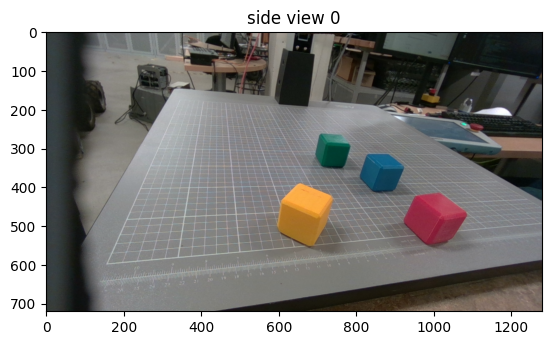

state={
    "objects": [
        "table",
        "yellow block",
        "green block",
        "blue block",
        "red block"
    ],
    "object_relationships": [
        [
            "yellow block",
            "table"
        ],
        [
            "green block",
            "table"
        ],
        [
            "blue block",
            "table"
        ],
        [
            "red block",
            "table"
        ]
    ]
}
next instruction={
    "done": false,
    "explanation": "To begin forming the desired stack, we need to start with the base. The green block should be at the base of the tower. Since the green block is already on the table, we can leave it there for now.",
    "pick": "none",
    "place": "none"
}
plan=[
    [
        "1",
        {
            "done": false,
            "explanation": "Next, we need to place the blue block on top of the green block to form the second layer of the tower. This will set up the foundation for the yellow block to be pl

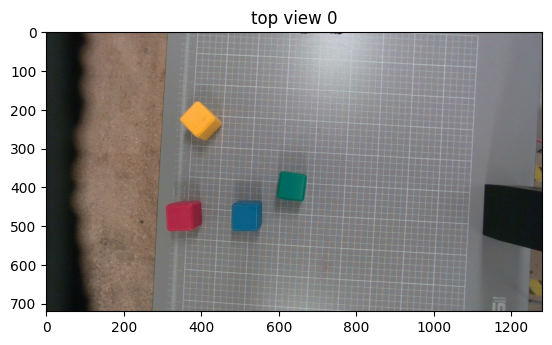

IndexError: index 0 is out of bounds for axis 0 with size 0

In [11]:

#tower = ["red block", "blue block", "green block", "yellow block", "purple block"]

n_attempts = 2*len(tower)
Done = 0
i = 0
save_dir = create_next_directory("./data_collection/")
action_history = []
previous_plan = []
while(not Done and i < n_attempts):
    interation_output_dir = os.path.join(save_dir, f"step {i}")
    os.makedirs(interation_output_dir, exist_ok=True)
    goto_vec(myrobot, sideview_vec)
    rgb_img, depth_img = get_pictures(myrs)
    plt.imshow(rgb_img)
    plt.title(f"side view {i}")
    plt.show()
    plt.imsave(os.path.join(interation_output_dir, "sideview.png"), rgb_img)

    (state_resp, state, state_sys_prompt, state_usr_promot), (instruction_resp, next_instruction, future_instructions, instruction_sys_prompt, instruction_usr_prompt) = get_gpt_next_instruction(client, rgb_img, tower, action_history, previous_plan)
    with open(os.path.join(interation_output_dir, "instruction.txt"), "w") as file:
        state_str = print_json(state, name="state")
        file.write(f"{state_str}\n")

        next_instruction_str = print_json(next_instruction, "next instruction")
        file.write(f"{next_instruction_str}")


        instruction_plan_str = print_json(future_instructions, name="plan")
        file.write(f"{instruction_plan_str}")

        file.write(f"{state_sys_prompt=}\n")
        file.write(f"{state_usr_promot=}\n")
        file.write(f"{instruction_sys_prompt=}\n")
        file.write(f"{instruction_usr_prompt=}\n")
    
    action_history.append(next_instruction)
    previous_plan = future_instructions
    Done = int(next_instruction["done"])
    
   

    if Done:
        break
    pick_str= next_instruction['pick']
    place_str= next_instruction['place']
    goto_vec(myrobot, topview_vec)
    rgb_img, depth_img = get_pictures(myrs)
    plt.imshow(rgb_img)
    plt.title(f"top view {i}")
    plt.show()
    plt.imsave(os.path.join(interation_output_dir, "topview.png"), rgb_img)
    pick_bb, place_bb = topview_pick_place_BB(myrobot, myrs, pick_str, place_str, display=True)
    pick(myrobot, pick_bb)
    place(myrobot, place_bb)
    i += 1
